In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy as sp
import corner
import arviz as az
from IPython.display import display, Math
from multiprocessing import Pool

import seaborn as sns
import time

import emcee as mc
import pymc3 as pm

import pickle
import h5py

sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)

/home/bryce_manubay/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#Read and configure Temp/Press data for posterior predictives
df = pd.read_csv("liquid_mass_dens_vs_T_P.csv")
T = df["Temp, F"].values
P = df["Press, psia"].values
y = df["Rho, g/cm3 * 10^4"].values/10000.

In [3]:
# Load hdf5 emcee sampler objects

# emcee files
file_emcee_sampler_UI = h5py.File('emcee_UI_priors_trace.h5','r+')
file_emcee_sampler_weak = h5py.File('emcee_weak_priors_trace.h5','r+')


samples_UI_emcee = file_emcee_sampler_UI['mcmc']['chain'][2000:]
log_prior_UI_emcee = file_emcee_sampler_UI['mcmc']['blobs']['log_prior'][2000:]
log_likelihood_UI_emcee = file_emcee_sampler_UI['mcmc']['blobs']['log_like'][2000:]

samples_weak_emcee = file_emcee_sampler_weak['mcmc']['chain'][2000:]
log_prior_weak_emcee = file_emcee_sampler_weak['mcmc']['blobs']['log_prior'][2000:]
log_likelihood_weak_emcee = file_emcee_sampler_weak['mcmc']['blobs']['log_like'][2000:]

file_emcee_sampler_UI.close()
file_emcee_sampler_weak.close()


In [4]:
file_emcee_sampler_UI.close()
file_emcee_sampler_weak.close()

In [5]:
def rho(theta,T,P):
    rho_T0_P0,alpha,T0,beta,P0,eps = theta
    return rho_T0_P0*(1 - alpha*(T-T0) + beta*(P-P0))

In [6]:
#reproduce emcee posterior predictives

posterior_predictive_UI_emcee = np.zeros(shape=(samples_UI_emcee.shape[0],len(T),samples_UI_emcee.shape[1]))
posterior_predictive_weak_emcee = np.zeros(shape=(samples_weak_emcee.shape[0],len(T),samples_weak_emcee.shape[1]))


for i in range(posterior_predictive_UI_emcee.shape[0]):
    theta_UI = samples_UI_emcee[i]
    for j in range(posterior_predictive_UI_emcee.shape[1]):
        T_ = T[j]
        P_ = P[j]
        for k in range(posterior_predictive_UI_emcee.shape[2]):
            posterior_predictive_UI_emcee[i,j,k]=rho(theta_UI[k],T_,P_)
        
for i in range(posterior_predictive_weak_emcee.shape[0]):
    theta_weak = samples_weak_emcee[i]
    for j in range(posterior_predictive_weak_emcee.shape[1]):
        T_ = T[j]
        P_ = P[j]
        for k in range(posterior_predictive_weak_emcee.shape[2]):
            posterior_predictive_weak_emcee[i,j,k]=rho(theta_weak[k],T_,P_)

In [5]:
# Load pickled PyMC3 models

# PyMC3 files
file_PyMC3_UI_model = open('PyMC3_UI_prior_model_MH_20.pkl', 'rb')
file_PyMC3_weak_model = open('PyMC3_UI_prior_model_NUTS_HA_long.pkl', 'rb')

# dump information to those files
PyMC3_UI_model = pickle.load(file_PyMC3_UI_model)
PyMC3_weak_model = pickle.load(file_PyMC3_weak_model)

# close the file
file_PyMC3_UI_model.close()
file_PyMC3_weak_model.close()

In [6]:
# Load pickled PyMC3 priors

# PyMC3 files
file_PyMC3_UI_prior = open('PyMC3_UI_prior_prior_MH_20.pkl', 'rb')
file_PyMC3_weak_prior = open('PyMC3_UI_prior_prior_NUTS_HA_long.pkl', 'rb')

# dump information to those files
PyMC3_UI_prior = pickle.load(file_PyMC3_UI_prior)
PyMC3_weak_prior = pickle.load(file_PyMC3_weak_prior)

# close the file
file_PyMC3_UI_prior.close()
file_PyMC3_weak_prior.close()

In [7]:
# Load pickled PyMC3 traces

# PyMC3 files
file_PyMC3_UI_trace = open('PyMC3_UI_prior_trace_MH_20.pkl', 'rb')
file_PyMC3_weak_trace = open('PyMC3_UI_prior_trace_NUTS_HA_long.pkl', 'rb')

# dump information to those files
PyMC3_UI_trace = pickle.load(file_PyMC3_UI_trace)
PyMC3_weak_trace = pickle.load(file_PyMC3_weak_trace)

# close the file
file_PyMC3_UI_trace.close()
file_PyMC3_weak_trace.close()

In [104]:
np.array(PyMC3_UI_trace.get_values("rho0",combine=False)).shape

(20, 30000)

In [8]:
labels=[r"$\rho\left(T_0,P_0\right)$",r"$\alpha$",r"$T_0$",r"$\beta$",r"$P_0$",r"$\epsilon$"]

In [9]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

In [10]:
flat_samples_UI_emcee = samples_UI_emcee.reshape(samples_UI_emcee.shape[0]*samples_UI_emcee.shape[1],6)
flat_samples_weak_emcee = samples_weak_emcee.reshape(samples_weak_emcee.shape[0]*samples_weak_emcee.shape[1],6)


In [11]:
#Extract and reshape our PyMC3 UI prior traces
rho0_UI = np.array(PyMC3_UI_trace.get_values("rho0",combine=False))
alpha_UI = np.array(PyMC3_UI_trace.get_values("alpha",combine=False))
T0_UI = np.array(PyMC3_UI_trace.get_values("T0",combine=False))
beta_UI = np.array(PyMC3_UI_trace.get_values("beta",combine=False))
P0_UI = np.array(PyMC3_UI_trace.get_values("P0",combine=False))
eps_UI = np.array(PyMC3_UI_trace.get_values("eps",combine=False))

var_container = [rho0_UI,alpha_UI,T0_UI,beta_UI,P0_UI,eps_UI]

samples_UI_PyMC3_ = np.stack(var_container, axis=2)

samples_UI_PyMC3_ = np.swapaxes(samples_UI_PyMC3_,0,1)

flat_samples_UI_PyMC3 = samples_UI_PyMC3_.reshape(samples_UI_PyMC3_.shape[0]*samples_UI_PyMC3_.shape[1],6)

In [12]:
#Extract and reshape our PyMC3 weak prior traces
rho0_weak = np.array(PyMC3_weak_trace.get_values("rho0",combine=False))
alpha_weak = np.array(PyMC3_weak_trace.get_values("alpha",combine=False))
T0_weak = np.array(PyMC3_weak_trace.get_values("T0",combine=False))
beta_weak = np.array(PyMC3_weak_trace.get_values("beta",combine=False))
P0_weak = np.array(PyMC3_weak_trace.get_values("P0",combine=False))
eps_weak = np.array(PyMC3_weak_trace.get_values("eps",combine=False))

var_container = [rho0_weak,alpha_weak,T0_weak,beta_weak,P0_weak,eps_weak]

samples_weak_PyMC3_ = np.stack(var_container, axis=2)

samples_weak_PyMC3_ = np.swapaxes(samples_weak_PyMC3_,0,1)

flat_samples_weak_PyMC3 = samples_weak_PyMC3_.reshape(samples_weak_PyMC3_.shape[0]*samples_weak_PyMC3_.shape[1],6)

<IPython.core.display.Javascript object>


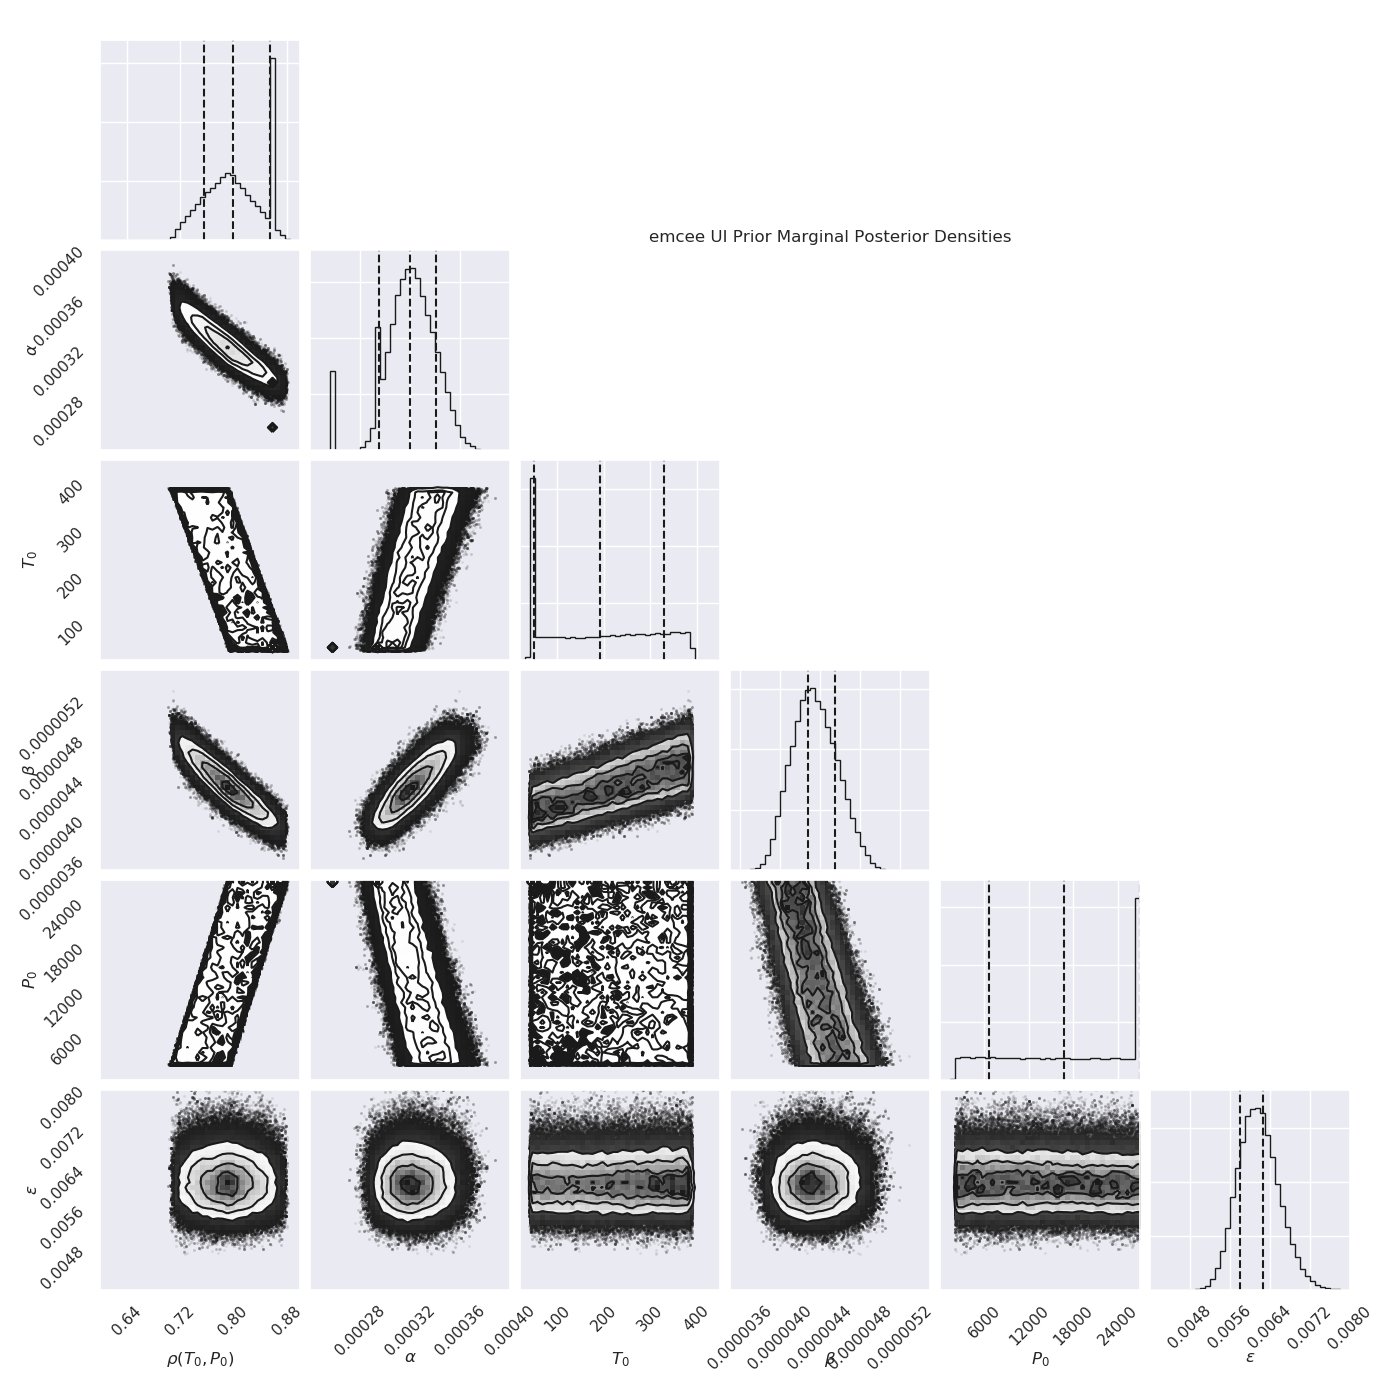

In [13]:
fig = corner.corner(flat_samples_UI_emcee, bins=40, quantiles=[0.16, 0.5, 0.84], range = [(0.6,0.9),(0.00024,0.0004),(20.,450.),(3.5e-6,5.5e-6),(0.,27000.),(0.004,0.008)], labels=labels, plot_density=True)
axs = np.array(fig.axes).reshape((6,6))
axs[1,3].set_title("emcee UI Prior Marginal Posterior Densities")
fig.savefig("figs/emcee_UI_cornerplot.png",bbox_inches='tight')

<IPython.core.display.Javascript object>


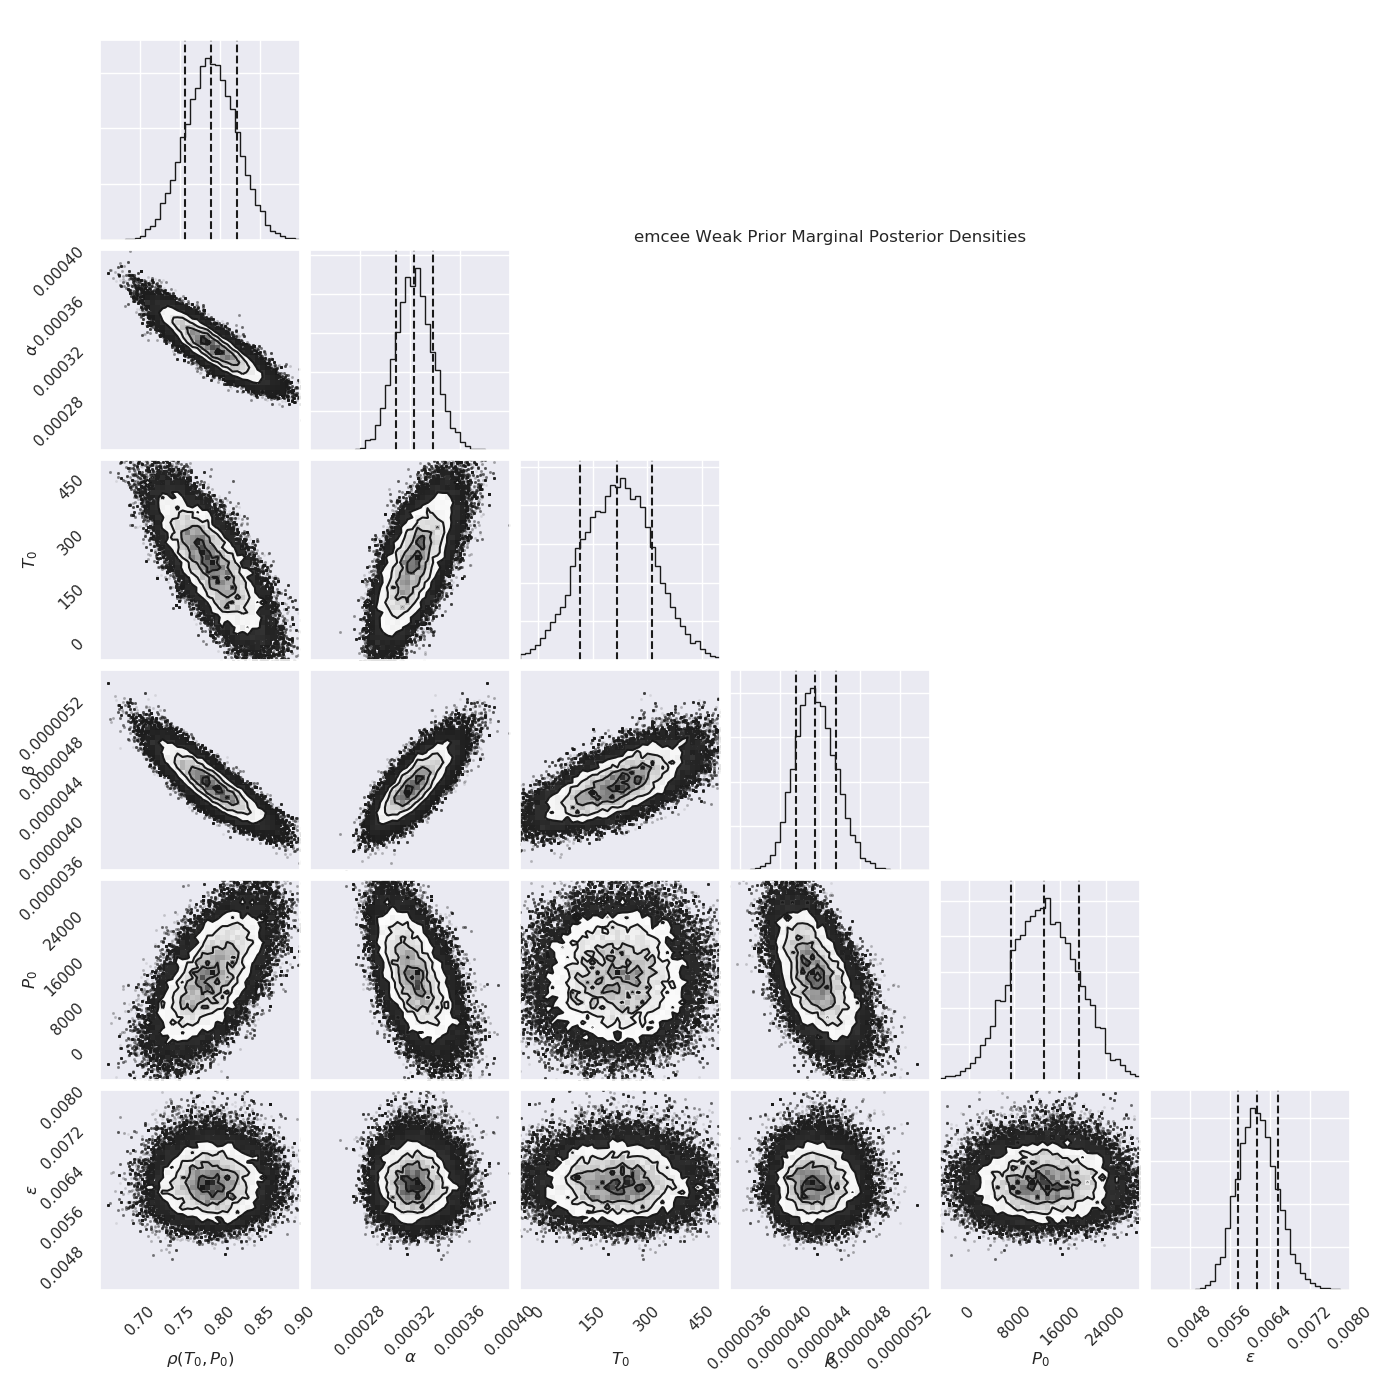

In [111]:
fig = corner.corner(flat_samples_weak_emcee, bins=40, quantiles=[0.16, 0.5, 0.84], range = [(0.65,0.9),(0.00024,0.0004),(-50.,500.),(3.5e-6,5.5e-6),(-5000.,30000.),(0.004,0.008)], labels=labels, plot_density=True)
axs = np.array(fig.axes).reshape((6,6))
axs[1,3].set_title("emcee Weak Prior Marginal Posterior Densities")
fig.savefig("figs/emcee_weak_cornerplot.png",bbox_inches='tight')

<IPython.core.display.Javascript object>


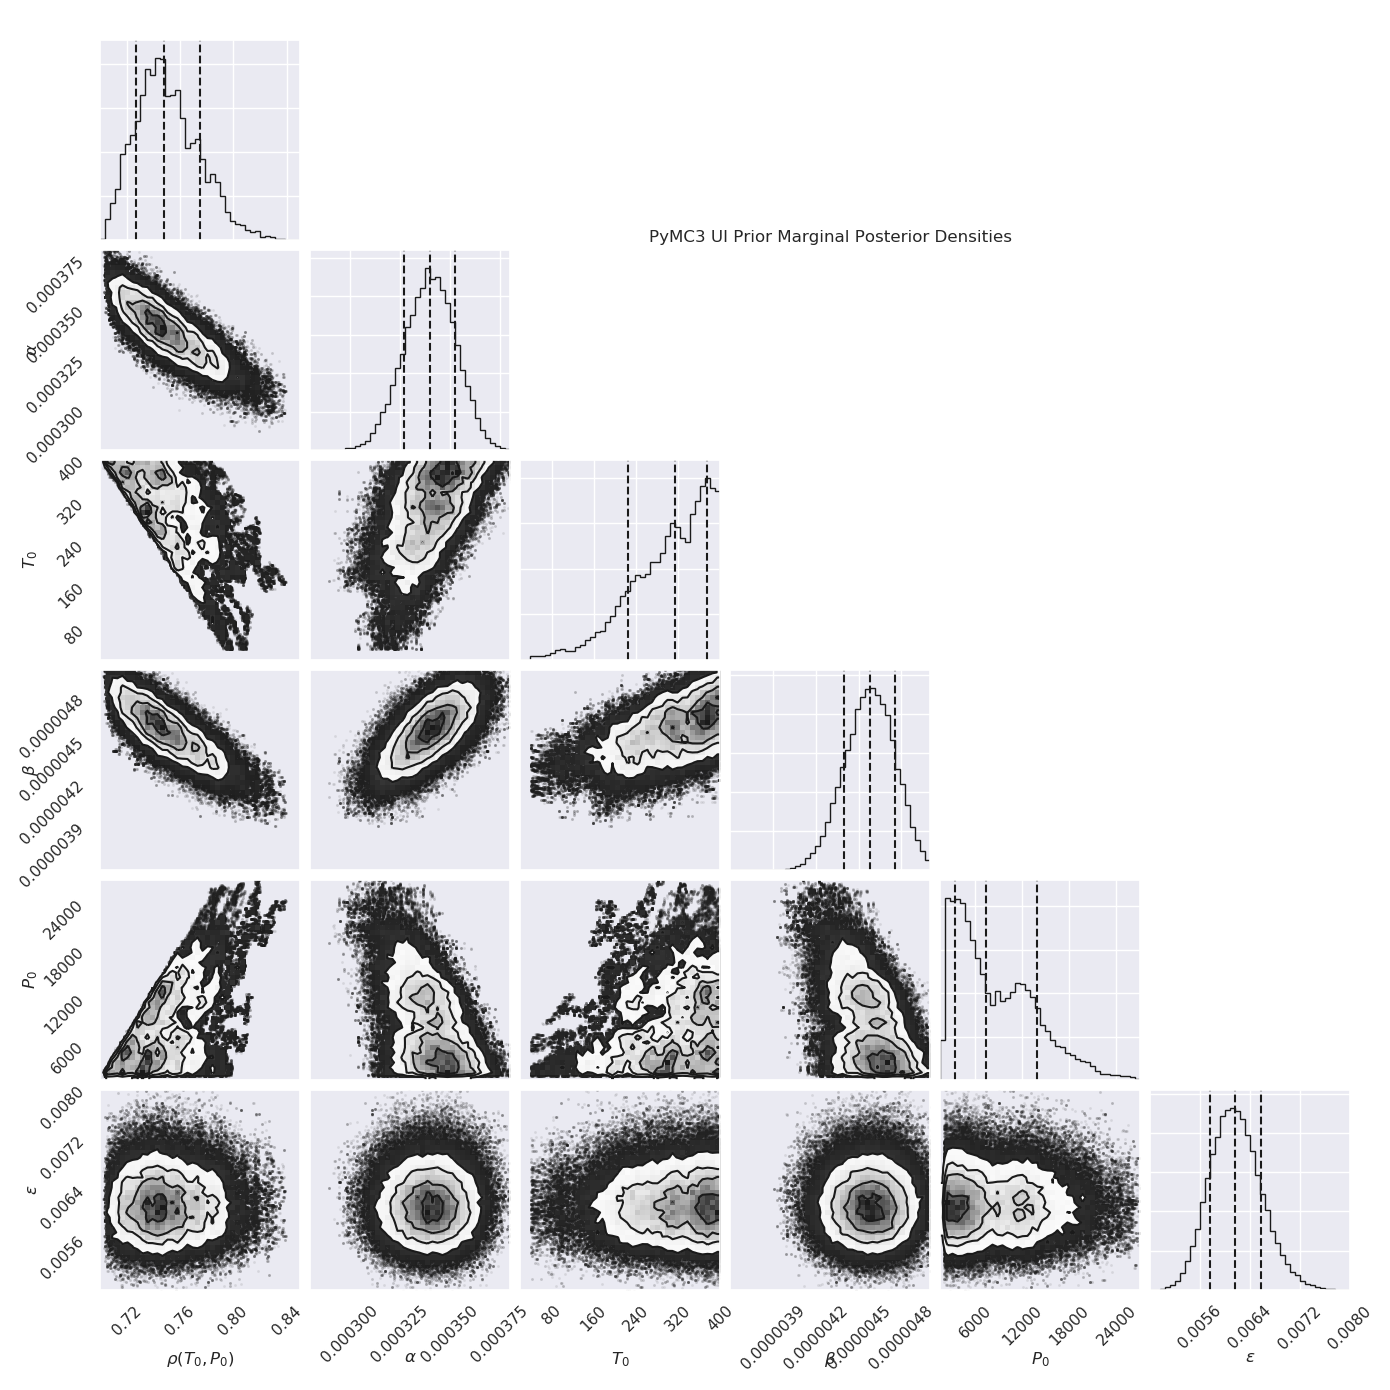

In [112]:
fig = corner.corner(flat_samples_UI_PyMC3, bins=40, quantiles=[0.16, 0.5, 0.84], range = [(0.7,0.85),(0.00028,0.00038),(20.,400.),(3.6e-6,5.0e-6),(1500.,27000.),(0.0048,0.008)], labels=labels, plot_density=True)
axs = np.array(fig.axes).reshape((6,6))
axs[1,3].set_title("PyMC3 UI Prior Marginal Posterior Densities")
fig.savefig("figs/PyMC3_UI_cornerplot.png",bbox_inches='tight')

<IPython.core.display.Javascript object>


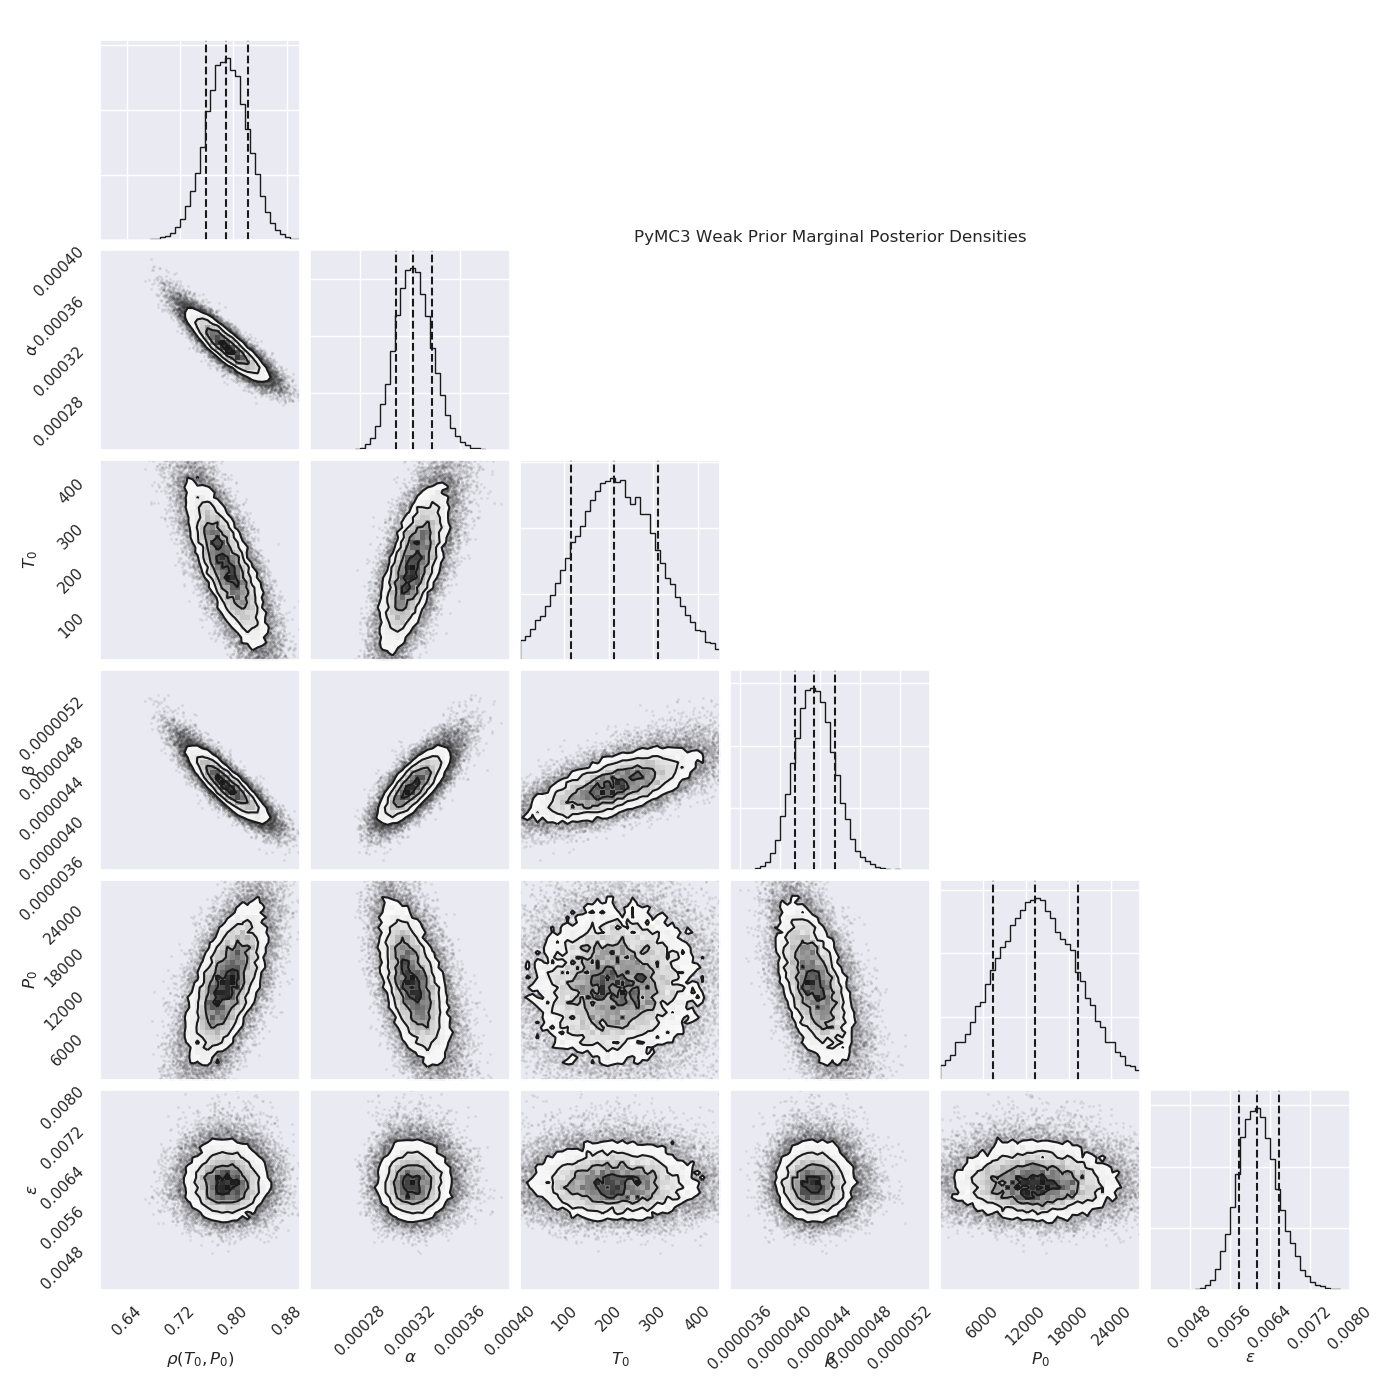

In [113]:
fig = corner.corner(flat_samples_weak_PyMC3, bins=40, quantiles=[0.16, 0.5, 0.84], range = [(0.6,0.9),(0.00024,0.0004),(0.,450.),(3.5e-6,5.5e-6),(0.,28000.),(0.004,0.008)], labels=labels, plot_density=True)
axs = np.array(fig.axes).reshape((6,6))
axs[1,3].set_title("PyMC3 Weak Prior Marginal Posterior Densities")
fig.savefig("figs/PyMC3_weak_cornerplot.png",bbox_inches='tight')

In [12]:
#reproduce the posterior predictives for PyMC3 models
with PyMC3_UI_model:
    PyMC3_UI_posterior = pm.sample_ppc(PyMC3_UI_trace)

with PyMC3_weak_model:
    PyMC3_weak_posterior = pm.sample_ppc(PyMC3_weak_trace)

100%|██████████| 3000/3000 [00:29<00:00, 100.15it/s]


<IPython.core.display.Javascript object>


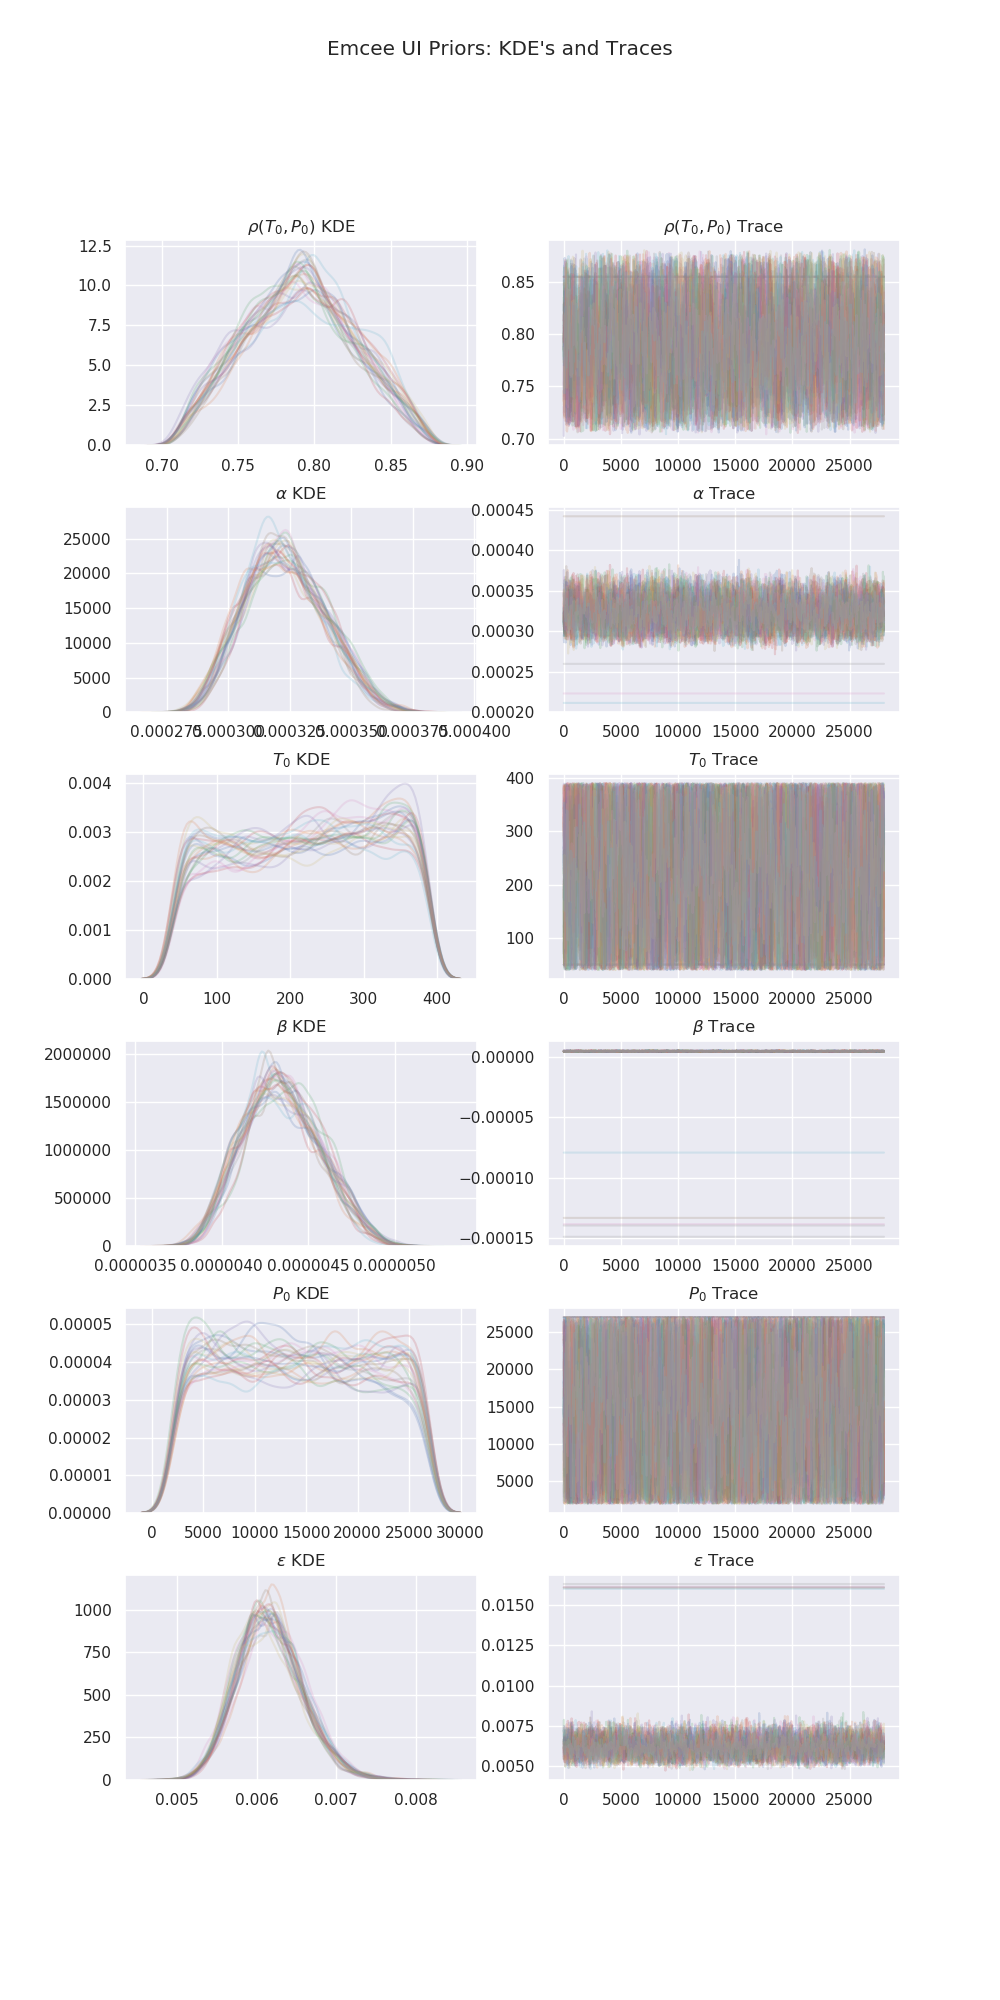

In [119]:
var_names = [r"$\rho\left(T_0,P_0\right)$",r"$\alpha$",r"$T_0$",r"$\beta$",r"$P_0$",r"$\epsilon$"]

fig, axs = plt.subplots(6,2, figsize=(10, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.2)
fig.suptitle("Emcee UI Priors: KDE's and Traces")

for i in range(samples_UI_emcee.shape[2]):
    var_i_all_chains = samples_UI_emcee[:,:,i]
    ax_kde=axs[i, 0]
    ax_trace=axs[i, 1]
    #set subplot titles
    ax_kde.set_title(var_names[i]+" KDE")
    ax_trace.set_title(var_names[i]+" Trace")
    for j in range(var_i_all_chains.shape[1]):
        #plot KDE estimate of var i for each chain j all on same subplot
        var_i_chain_j = var_i_all_chains[:,j]
        sns.kdeplot(var_i_chain_j, ax=ax_kde, **{"alpha":0.2})
        #plot trace of var i for each chain j all on same subplot
        step_number = [i for i in range(len(var_i_chain_j))]
        ax_trace.plot(step_number, var_i_chain_j, alpha=0.2)

fig.savefig("figs/emcee_UI_KDE_and_traces.png",bbox_inches='tight')

<IPython.core.display.Javascript object>


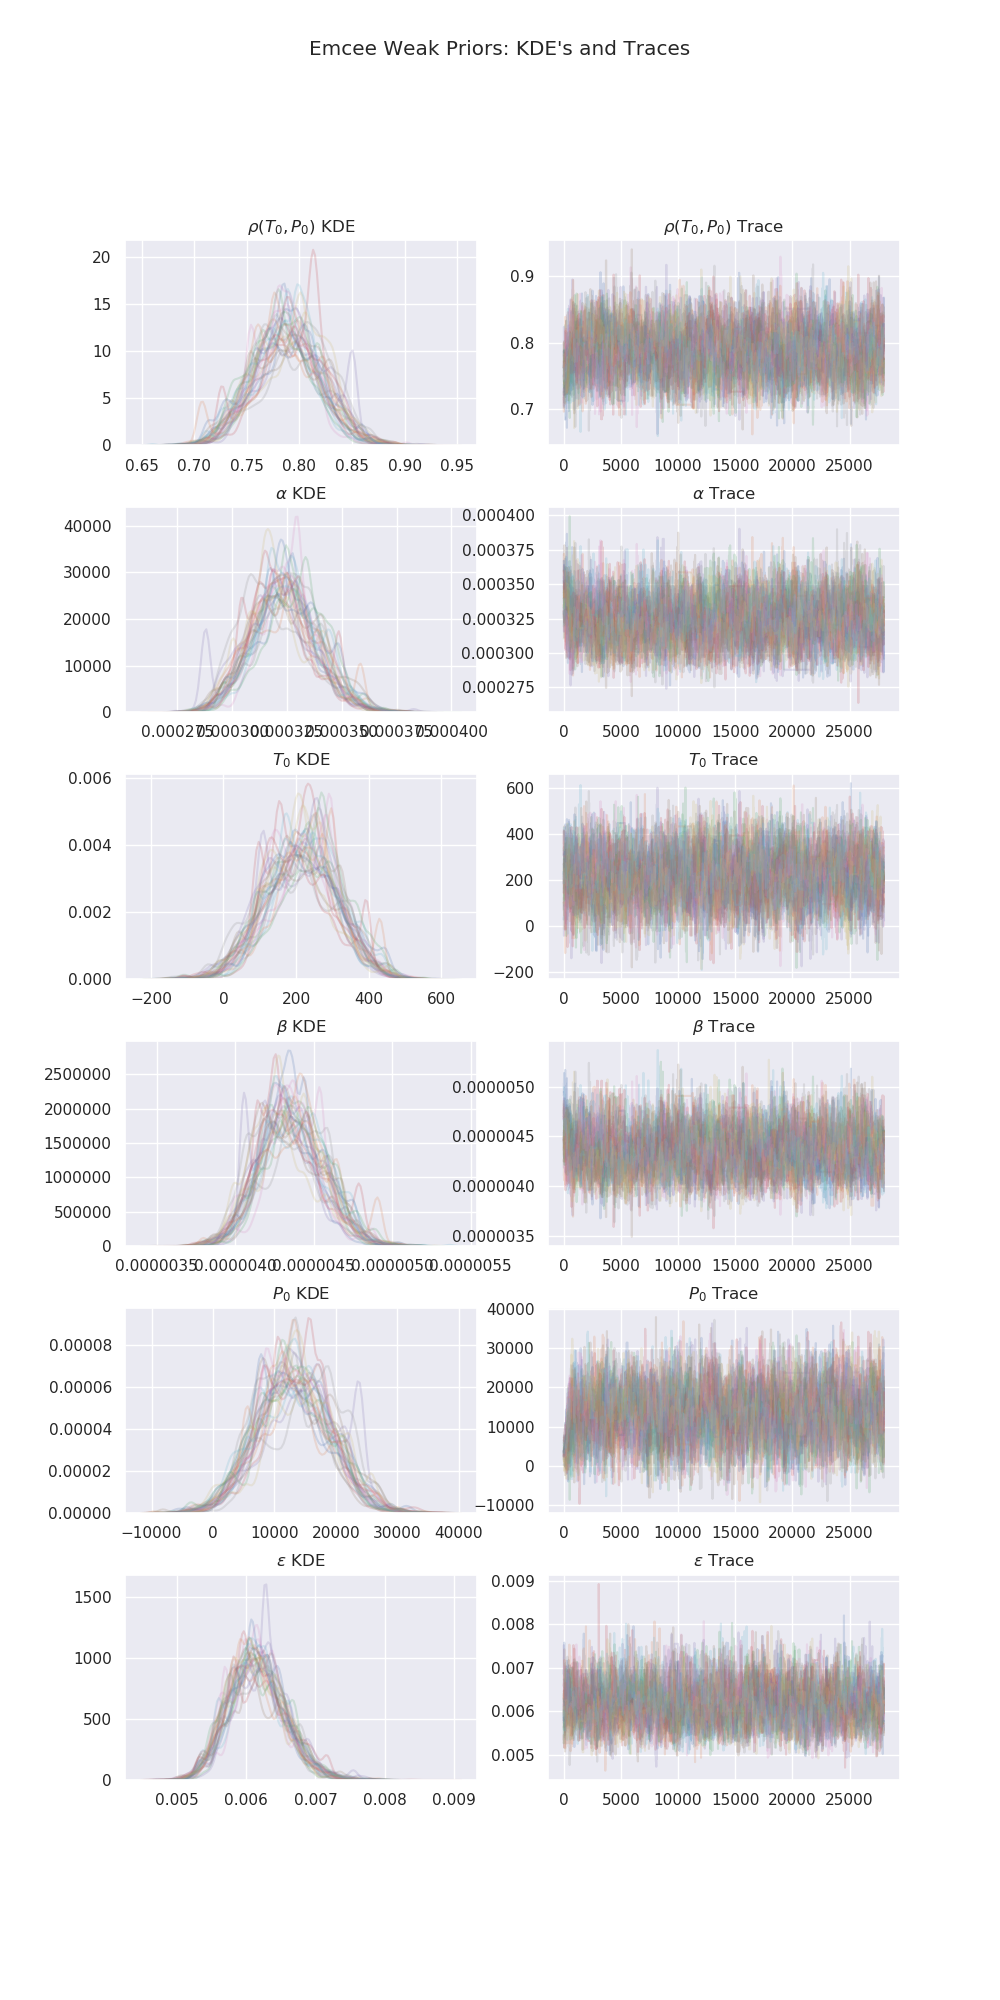

In [120]:
fig, axs = plt.subplots(6,2, figsize=(10, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.2)
fig.suptitle("Emcee Weak Priors: KDE's and Traces")

for i in range(samples_weak_emcee.shape[2]):
    var_i_all_chains = samples_weak_emcee[:,:,i]
    ax_kde=axs[i, 0]
    ax_trace=axs[i, 1]
    #set subplot titles
    ax_kde.set_title(var_names[i]+" KDE")
    ax_trace.set_title(var_names[i]+" Trace")
    for j in range(var_i_all_chains.shape[1]):
        #plot KDE estimate of var i for each chain j all on same subplot
        var_i_chain_j = var_i_all_chains[:,j]
        sns.kdeplot(var_i_chain_j, ax=ax_kde, **{"alpha":0.2})
        #plot trace of var i for each chain j all on same subplot
        step_number = [i for i in range(len(var_i_chain_j))]
        ax_trace.plot(step_number, var_i_chain_j, alpha=0.2)

fig.savefig("figs/emcee_weak_KDE_and_traces.png",bbox_inches='tight')

<IPython.core.display.Javascript object>


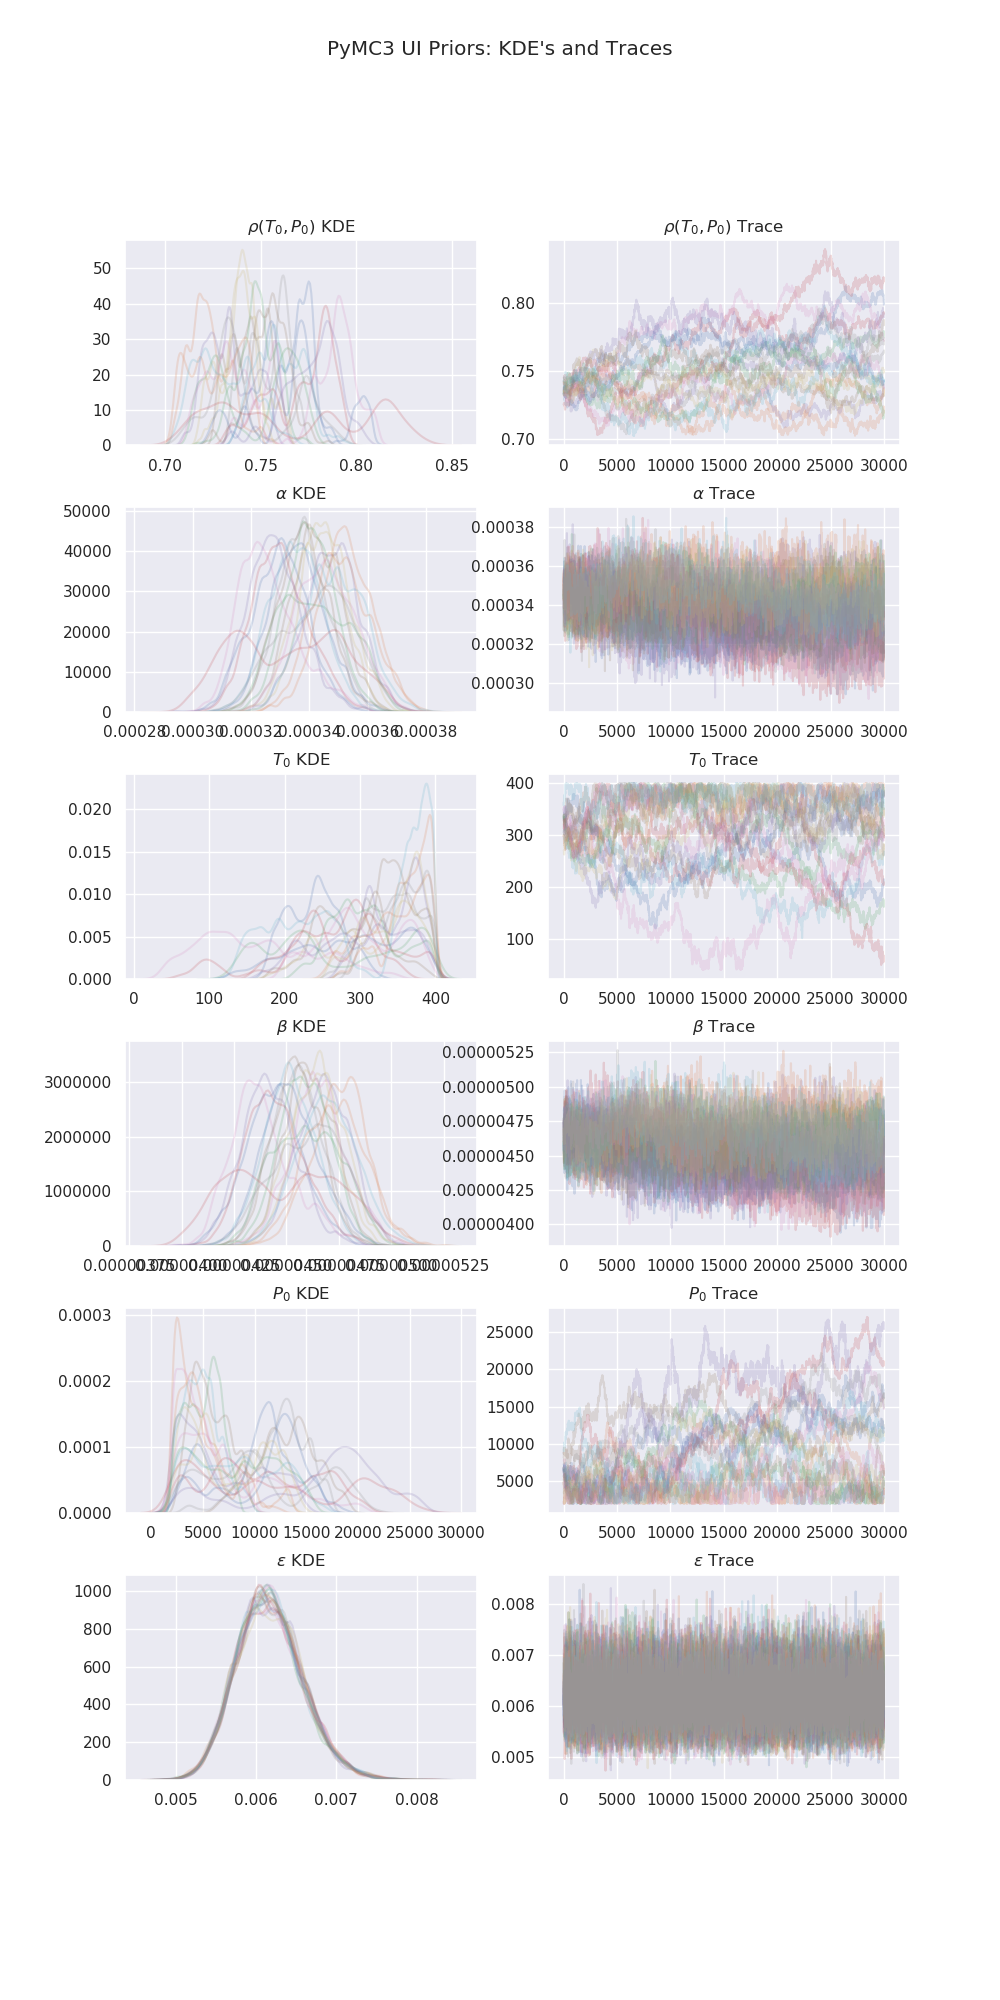

In [121]:
fig, axs = plt.subplots(6,2, figsize=(10, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.2)
fig.suptitle("PyMC3 UI Priors: KDE's and Traces")

for i in range(samples_UI_PyMC3_.shape[2]):
    var_i_all_chains = samples_UI_PyMC3_[:,:,i]
    ax_kde=axs[i, 0]
    ax_trace=axs[i, 1]
    #set subplot titles
    ax_kde.set_title(var_names[i]+" KDE")
    ax_trace.set_title(var_names[i]+" Trace")
    for j in range(var_i_all_chains.shape[1]):
        #plot KDE estimate of var i for each chain j all on same subplot
        var_i_chain_j = var_i_all_chains[:,j]
        sns.kdeplot(var_i_chain_j, ax=ax_kde, **{"alpha":0.2})
        #plot trace of var i for each chain j all on same subplot
        step_number = [i for i in range(len(var_i_chain_j))]
        ax_trace.plot(step_number, var_i_chain_j, alpha=0.2)

fig.savefig("figs/PyMC3_UI_KDE_and_traces.png",bbox_inches='tight')

<IPython.core.display.Javascript object>


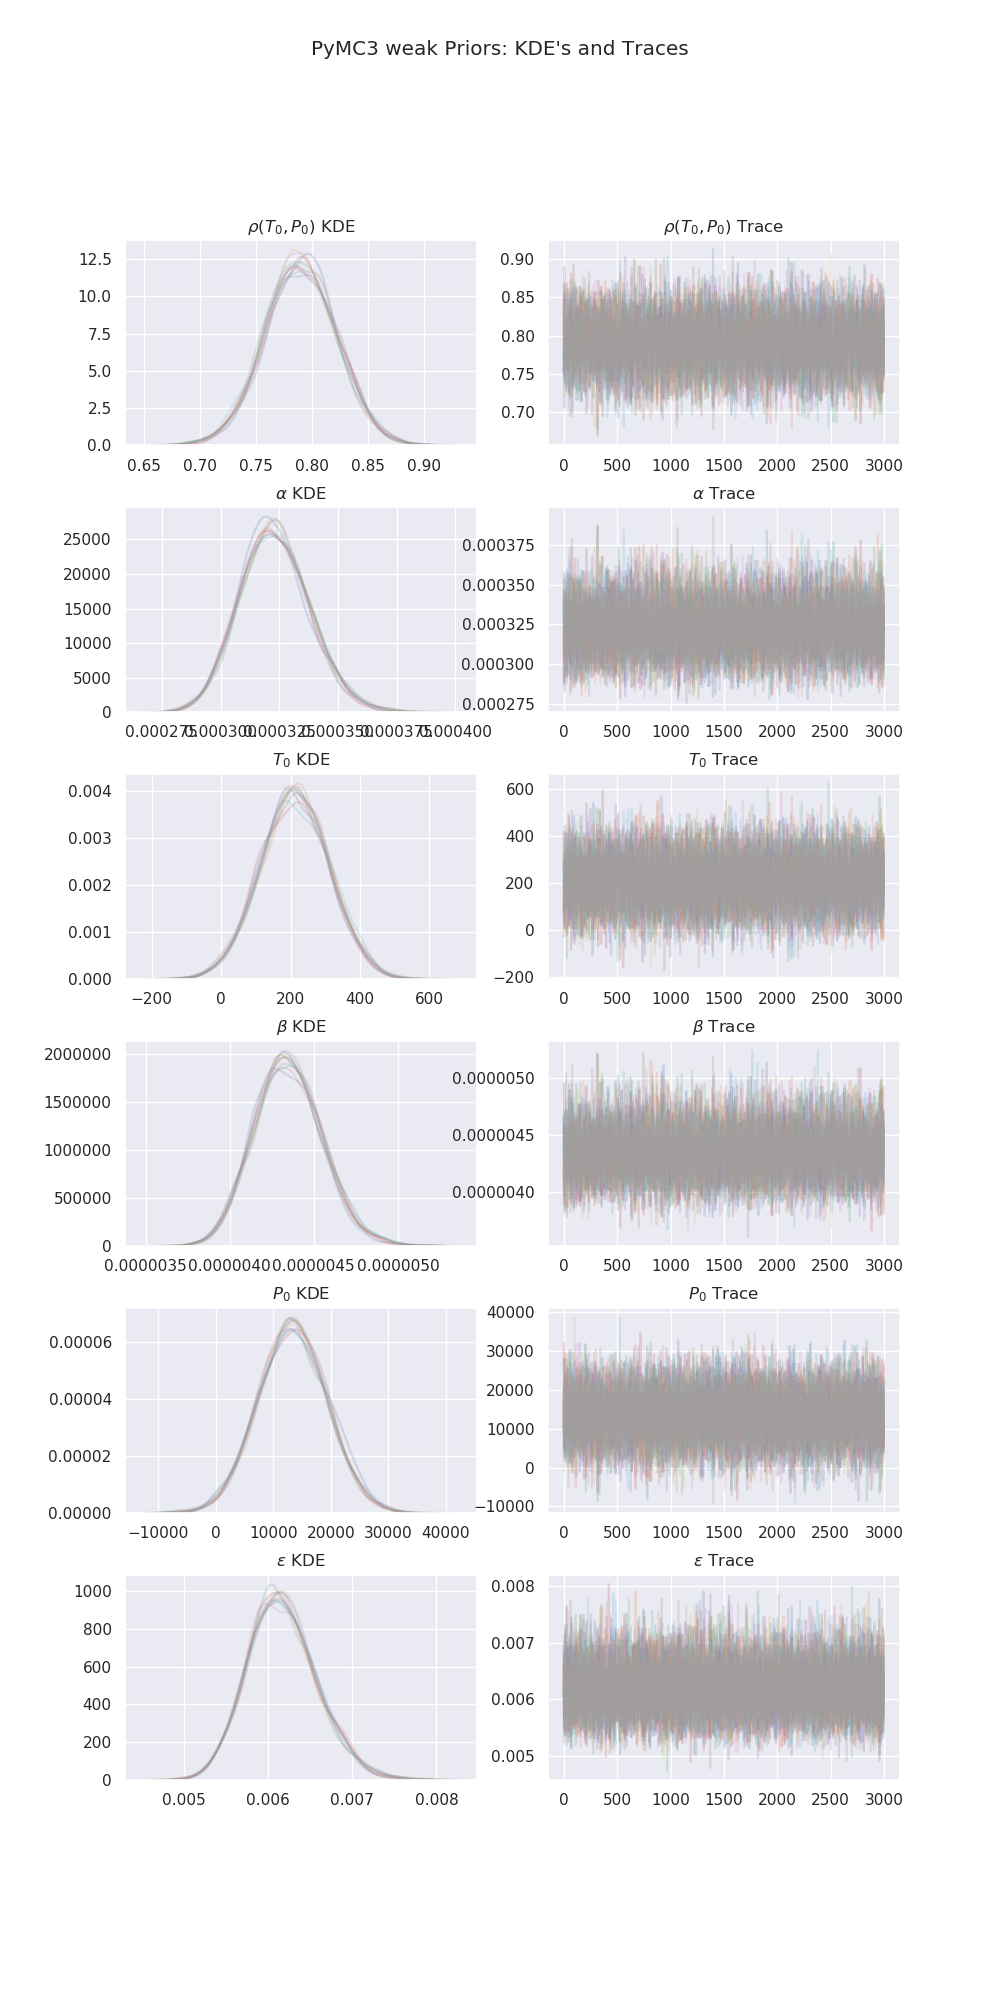

In [122]:
fig, axs = plt.subplots(6,2, figsize=(10, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.2)
fig.suptitle("PyMC3 weak Priors: KDE's and Traces")

for i in range(samples_weak_PyMC3_.shape[2]):
    var_i_all_chains = samples_weak_PyMC3_[:,:,i]
    ax_kde=axs[i, 0]
    ax_trace=axs[i, 1]
    #set subplot titles
    ax_kde.set_title(var_names[i]+" KDE")
    ax_trace.set_title(var_names[i]+" Trace")
    for j in range(var_i_all_chains.shape[1]):
        #plot KDE estimate of var i for each chain j all on same subplot
        var_i_chain_j = var_i_all_chains[:,j]
        sns.kdeplot(var_i_chain_j, ax=ax_kde, **{"alpha":0.2})
        #plot trace of var i for each chain j all on same subplot
        step_number = [i for i in range(len(var_i_chain_j))]
        ax_trace.plot(step_number, var_i_chain_j, alpha=0.2)

fig.savefig("figs/PyMC3_weak_KDE_and_traces.png",bbox_inches='tight')

<IPython.core.display.Javascript object>


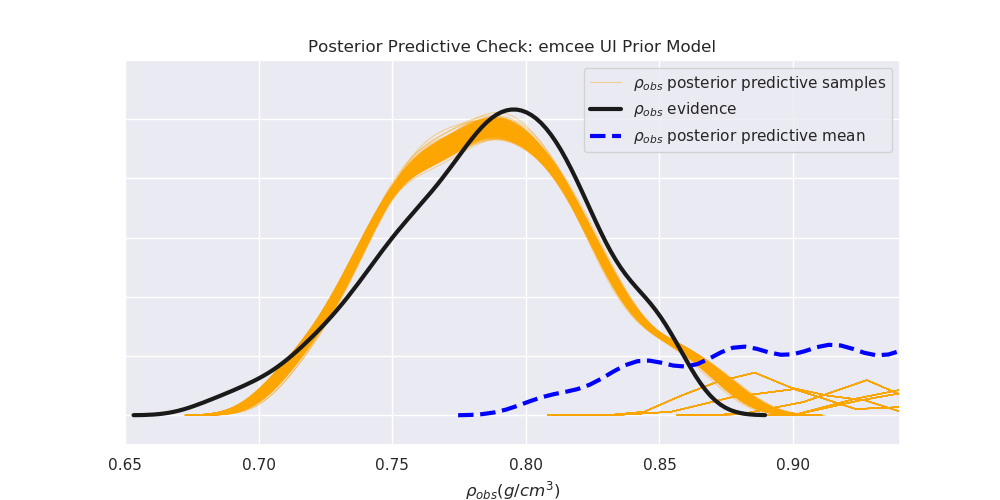

In [123]:
fig, axs = plt.subplots(figsize=(10, 5), facecolor='w', edgecolor='k')
plt.ylim(-1,12)
rand_idx_1 = np.random.randint(low=0, high=posterior_predictive_UI_emcee.shape[0], size=800)
rand_idx_2 = np.random.randint(low=0, high=posterior_predictive_UI_emcee.shape[2], size=800)
for i,j in zip(rand_idx_1,rand_idx_2):
    sns.kdeplot(posterior_predictive_UI_emcee[i,:,j], ax=axs, color='orange',
                bw=0.01,linewidth=0.8, label=r"$\rho_{obs}$ posterior predictive samples", **{"alpha":0.4})   

sns.kdeplot(y, ax=axs, bw=0.01, color='k', linewidth=3, label=r"$\rho_{obs}$ evidence")
ppc_av = np.mean(posterior_predictive_UI_emcee[rand_idx_1,:,rand_idx_2],axis=0)
sns.kdeplot(ppc_av, ax=axs, bw=0.01, color='blue', linestyle="--", linewidth=3, label=r"$\rho_{obs}$ posterior predictive mean")


axs.set_ylim([-1,12])
axs.set_xlim([0.65,0.94])
axs.yaxis.set_ticklabels([])

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)

axs.set_xlabel(r"$\rho_{obs} (g/{cm}^3)$")
axs.set_title("Posterior Predictive Check: emcee UI Prior Model")

fig.savefig("figs/emcee_UI_prior_PPCplot.png",bbox_inches='tight')

<IPython.core.display.Javascript object>


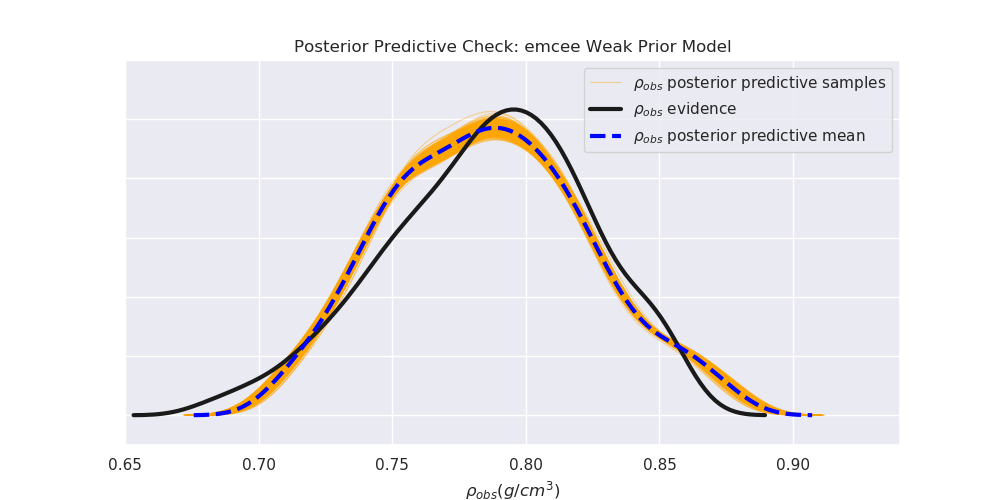

In [124]:
fig, axs = plt.subplots(figsize=(10, 5), facecolor='w', edgecolor='k')
plt.ylim(-1,12)
rand_idx_1 = np.random.randint(low=0, high=posterior_predictive_weak_emcee.shape[0], size=800)
rand_idx_2 = np.random.randint(low=0, high=posterior_predictive_weak_emcee.shape[2], size=800)
for i,j in zip(rand_idx_1,rand_idx_2):
    sns.kdeplot(posterior_predictive_weak_emcee[i,:,j], ax=axs, color='orange',
                bw=0.01,linewidth=0.8, label=r"$\rho_{obs}$ posterior predictive samples", **{"alpha":0.4})   

sns.kdeplot(y, ax=axs, bw=0.01, color='k', linewidth=3, label=r"$\rho_{obs}$ evidence")
ppc_av = np.mean(posterior_predictive_weak_emcee[rand_idx_1,:,rand_idx_2],axis=0)
sns.kdeplot(ppc_av, ax=axs, bw=0.01, color='blue', linestyle="--", linewidth=3, label=r"$\rho_{obs}$ posterior predictive mean")


axs.set_ylim([-1,12])
axs.set_xlim([0.65,0.94])
axs.yaxis.set_ticklabels([])

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)

axs.set_xlabel(r"$\rho_{obs} (g/{cm}^3)$")
axs.set_title("Posterior Predictive Check: emcee Weak Prior Model")

fig.savefig("figs/emcee_weak_prior_PPCplot.png",bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5), facecolor='w', edgecolor='k')
plt.ylim(-1,12)
rand_idx = np.random.randint(low=0, high=PyMC3_UI_posterior["rho_obs"].shape[0], size=800)
for i in rand_idx:
    sns.kdeplot(PyMC3_UI_posterior["rho_obs"][i,:], ax=axs, color='orange',
                bw=0.01,linewidth=0.8, label=r"$\rho_{obs}$ posterior predictive samples", **{"alpha":0.4})   

sns.kdeplot(y, ax=axs, bw=0.01, color='k', linewidth=3, label=r"$\rho_{obs}$ evidence")
ppc_av = np.mean(PyMC3_UI_posterior["rho_obs"][rand_idx,:],axis=0)
sns.kdeplot(ppc_av, ax=axs, bw=0.01, color='blue', linestyle="--", linewidth=3, label=r"$\rho_{obs}$ posterior predictive mean")


axs.set_ylim([-1,12])
axs.set_xlim([0.65,0.94])
axs.yaxis.set_ticklabels([])

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)

axs.set_xlabel(r"$\rho_{obs} (g/{cm}^3)$")
axs.set_title("Posterior Predictive Check: PyMC3 UI Prior Model")

fig.savefig("figs/PyMC3_UI_prior_PPCplot.png",bbox_inches='tight')

In [ ]:
#plot ppc's
fig, axs = plt.subplots(figsize=(10, 5), facecolor='w', edgecolor='k')
plt.ylim(-1,12)
rand_idx = np.random.randint(low=0, high=PyMC3_weak_posterior["rho_obs"].shape[0], size=800)
for i in rand_idx:
    sns.kdeplot(PyMC3_weak_posterior["rho_obs"][i,:], ax=axs, color='orange',
                bw=0.01,linewidth=0.8, label=r"$\rho_{obs}$ posterior predictive samples", **{"alpha":0.4})   

sns.kdeplot(y, ax=axs, bw=0.01, color='k', linewidth=3, label=r"$\rho_{obs}$ evidence")
ppc_av = np.mean(PyMC3_weak_posterior["rho_obs"][rand_idx,:],axis=0)
sns.kdeplot(ppc_av, ax=axs, bw=0.01, color='blue', linestyle="--", linewidth=3, label=r"$\rho_{obs}$ posterior predictive mean")


axs.set_ylim([-1,12])
axs.set_xlim([0.65,0.94])
axs.yaxis.set_ticklabels([])

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)

axs.set_xlabel(r"$\rho_{obs} (g/{cm}^3)$")
axs.set_title("Posterior Predictive Check: PyMC3 Hierarchical Model")

fig.savefig("figs/PyMC3_HA_model_PPCplot.png",bbox_inches='tight')

In [22]:
samples_UI_emcee = np.swapaxes(samples_UI_emcee, axis1=0,axis2=1)
samples_weak_emcee = np.swapaxes(samples_weak_emcee, axis1=0,axis2=1)

datadict_UI = {
    'rho0': samples_UI_emcee[:,:,0],
    'alpha': samples_UI_emcee[:,:,1],
    'T0': samples_UI_emcee[:,:,2],
    'beta': samples_UI_emcee[:,:,3],
    'P0': samples_UI_emcee[:,:,4],
    'eps': samples_UI_emcee[:,:,5]
}
datadict_weak = {
    'rho0': samples_weak_emcee[:,:,0],
    'alpha': samples_weak_emcee[:,:,1],
    'T0': samples_weak_emcee[:,:,2],
    'beta': samples_weak_emcee[:,:,3],
    'P0': samples_weak_emcee[:,:,4],
    'eps': samples_weak_emcee[:,:,5]
}


data_emcee_UI = az.convert_to_inference_data(datadict_UI)
data_emcee_weak = az.convert_to_inference_data(datadict_weak)

In [23]:
#summary stats PyMC3
data_pymc3_UI = az.from_pymc3(trace=PyMC3_UI_trace,
                     prior=PyMC3_UI_prior,
                     posterior_predictive=PyMC3_UI_posterior)
data_pymc3_weak = az.from_pymc3(trace=PyMC3_weak_trace,
                     prior=PyMC3_weak_prior,
                     posterior_predictive=PyMC3_weak_posterior)


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [24]:
print("emcee UI Priors Summary Statistics")
az.summary(data_emcee_UI, var_names=["rho0","alpha","T0","beta","P0","eps"],round_to=7)

emcee UI Priors Summary Statistics


mean           sd       hpd_3%       hpd_97%   mcse_mean  \
rho0       0.801446     0.040902     0.726501      0.855554    0.004382   
alpha      0.000317     0.000040     0.000211      0.000355    0.000007   
T0       193.585488   112.786145    49.978111    376.080655   11.656630   
beta      -0.000018     0.000050    -0.000140      0.000005    0.000009   
P0     16441.957540  8106.581141  3738.373614  26999.775349  854.745506   
eps        0.007829     0.003730     0.005459      0.016137    0.000678   

          mcse_sd   ess_mean     ess_sd   ess_bulk     ess_tail     r_hat  
rho0     0.003164  87.134261  84.150419  94.190609  7733.270976  1.226586  
alpha    0.000005  34.986098  34.986098  55.709502    30.008574  1.488709  
T0       8.268299  93.619316  93.619316  85.531245    50.692179  1.256258  
beta     0.000007  30.009067  30.008576  64.053415    30.008574  1.391549  
P0     701.314070  89.950134  67.390606  63.860098    30.008574  1.388536  
eps      0.000485  30.317752  30.105769  63.478725    30.008574  1.389612

In [25]:
print("emcee Weak Priors Summary Statistics")
az.summary(data_emcee_weak, var_names=["rho0","alpha","T0","beta","P0","eps"],round_to=7)

emcee Weak Priors Summary Statistics


mean            sd       hpd_3%       hpd_97%     mcse_mean  \
rho0       0.788623  3.235970e-02     0.729731      0.850625  9.309000e-04   
alpha      0.000324  1.500000e-05     0.000294      0.000351  5.000000e-07   
T0       216.143940  9.869032e+01    24.992755    393.455934  2.649196e+00   
beta       0.000004  2.000000e-07     0.000004      0.000005  0.000000e+00   
P0     13273.783045  5.980008e+03  1978.904930  24052.855086  1.612185e+02   
eps        0.006158  4.055000e-04     0.005428      0.006942  1.000000e-05   

            mcse_sd     ess_mean       ess_sd     ess_bulk     ess_tail  \
rho0   6.584000e-04  1208.384977  1208.384977  1205.904842  2351.019403   
alpha  3.000000e-07  1019.395385  1019.395385  1003.623838  2265.303709   
T0     1.873658e+00  1387.780706  1387.780706  1391.786826  2844.664471   
beta   0.000000e+00  1032.470535  1032.470535  1018.274779  2723.754955   
P0     1.140229e+02  1375.857910  1375.857910  1375.816648  2471.547604   
eps    7.100000e-06  1645.582398  1645.582398  1631.988695  4709.097778   

          r_hat  
rho0   1.027605  
alpha  1.031861  
T0     1.026286  
beta   1.029054  
P0     1.024939  
eps    1.015137

In [26]:
print("PyMC3 UI Priors Summary Statistics")
az.summary(data_pymc3_UI, var_names=["rho0","alpha","T0","beta","P0","eps"],round_to=7)

PyMC3 UI Priors Summary Statistics


mean            sd       hpd_3%       hpd_97%   mcse_mean  \
rho0      0.750686  2.350190e-02     0.709863      0.793619    0.004515   
alpha     0.000340  1.280000e-05     0.000315      0.000363    0.000002   
T0      301.983875  7.323485e+01   172.562001    399.999848   13.543830   
beta      0.000005  2.000000e-07     0.000004      0.000005    0.000000   
P0     8598.895346  5.102482e+03  2000.002731  17666.030692  902.201338   
eps       0.006174  4.137000e-04     0.005416      0.006959    0.000002   

          mcse_sd      ess_mean        ess_sd      ess_bulk      ess_tail  \
rho0     0.003231     27.096774     27.043497     28.071887     46.861561   
alpha    0.000001     39.817647     39.817647     40.289898     79.402821   
T0       9.674126     29.238331     29.238331     32.260827     56.392312   
beta     0.000000     41.342669     41.342669     41.765410     88.911394   
P0     651.288402     31.985718     31.273719     37.422820     48.542309   
eps      0.000001  59915.088872  59855.539389  60086.674824  63602.368006   

          r_hat  
rho0   1.914858  
alpha  1.425597  
T0     1.663536  
beta   1.400497  
P0     1.486219  
eps    1.000525

In [27]:
print("PyMC3 Weak Priors Summary Statistics")
az.summary(data_pymc3_weak, var_names=["rho0","alpha","T0","beta","P0","eps"],round_to=7)

PyMC3 Weak Priors Summary Statistics


mean            sd       hpd_3%       hpd_97%     mcse_mean  \
rho0       0.789805  3.180530e-02     0.728902      0.848824  3.373000e-04   
alpha      0.000323  1.480000e-05     0.000296      0.000351  2.000000e-07   
T0       212.925263  9.861915e+01    25.348039    397.418524  9.067141e-01   
beta       0.000004  2.000000e-07     0.000004      0.000005  0.000000e+00   
P0     13382.060105  5.944398e+03  2028.159311  24339.466419  4.889516e+01   
eps        0.006173  4.130000e-04     0.005431      0.006978  2.800000e-06   

            mcse_sd      ess_mean        ess_sd      ess_bulk      ess_tail  \
rho0   2.385000e-04   8892.783158   8892.783158   8892.406076  11949.203229   
alpha  1.000000e-07   9566.451946   9519.728679   9660.944265  13212.771052   
T0     6.553601e-01  11829.919350  11322.829519  11837.614440  15914.960578   
beta   0.000000e+00   9751.496956   9696.422114   9849.271917  12599.585438   
P0     3.457478e+01  14780.327323  14780.327323  14781.612353  17164.372434   
eps    2.000000e-06  22183.467358  21939.695373  22426.111144  18629.731466   

          r_hat  
rho0   1.000528  
alpha  1.000591  
T0     1.000895  
beta   1.000627  
P0     1.000458  
eps    1.000327

In [14]:
#Read and configure Temp/Press data for posterior predictives
df = pd.read_csv("liquid_mass_dens_vs_T_P.csv")
T = df["Temp, F"].values
P = df["Press, psia"].values
y = df["Rho, g/cm3 * 10^4"].values/10000.
xData = df[["Temp, F","Press, psia"]].values.swapaxes(0,1)

In [15]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings


def func(x_, rho0, alpha, T0, beta, P0): 
    T,P = x_
    return  rho0*(1. - alpha*(T-T0) + beta*(P-P0))


# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((y - val) ** 2.0)


def generate_Initial_Parameters():
    # min and max used for bounds

    parameterBounds = []
    parameterBounds.append([0., 1.]) # seach bounds for rho0_T0_P0
    parameterBounds.append([0., 1.]) # seach bounds for alpha
    parameterBounds.append([0., 400.]) # seach bounds for T0
    parameterBounds.append([0., 1.]) # seach bounds for beta
    parameterBounds.append([0., 30000.]) # seach bounds P0

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

# generate initial parameter values
geneticParameters = generate_Initial_Parameters()

# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, y, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - y

SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(y))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)

print()


Parameters [ 6.96043153e-01  3.66107982e-04  3.88482810e+02  4.92897327e-06
 -9.09679660e+02]
RMSE: 0.006027682646005505
R-squared: 0.9745511788152698



In [ ]:
fig,ax = plt.subplots(ncols=1)
x = np.linspace(0.7,0.86)
ax.plot(x, x)
rand_idx_1 = np.random.randint(low=0, high=posterior_predictive_UI_emcee.shape[0], size=3000)
rand_idx_2 = np.random.randint(low=0, high=posterior_predictive_UI_emcee.shape[2], size=3000)
for i,j in zip(rand_idx_1,rand_idx_2):
    ax.plot(y, posterior_predictive_UI_emcee[i,:,j],"o",color="orange",label=r"$\rho_{obs}$ posterior predictive samples",alpha=0.4)

ax.plot(y,modelPredictions,"x",color="blue",markersize=10,label=r"$\rho_{obs}$ genetic algorithm predictions",alpha=0.4)

ax.set_xlabel(r"$\rho_{obs} (g/{cm}^3)$, evidence")
ax.set_ylabel(r"$\rho_{obs} (g/{cm}^3)$, posterior predictive")
ax.set_title("Evidence vs. Posterior Predictive: emcee UI Prior Model")

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)
    
fig.savefig("figs/emcee_UI_prior_actualvspredictedplot.png",bbox_inches='tight')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


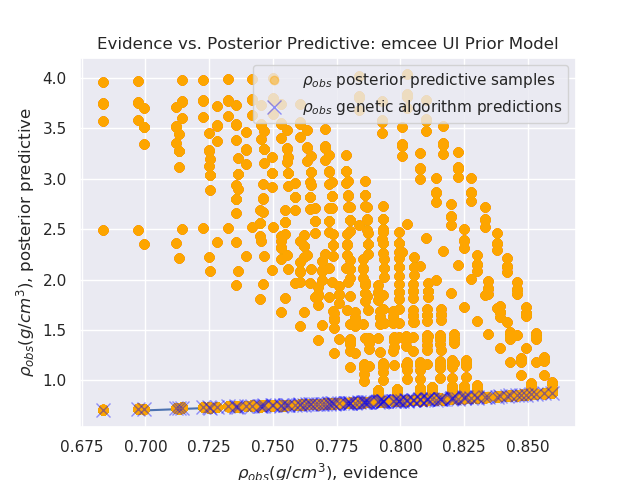

In [16]:
fig,ax = plt.subplots(ncols=1)
x = np.linspace(0.7,0.86)
ax.plot(x, x)
rand_idx_1 = np.random.randint(low=0, high=posterior_predictive_UI_emcee.shape[0], size=3000)
rand_idx_2 = np.random.randint(low=0, high=posterior_predictive_UI_emcee.shape[2], size=3000)
for i,j in zip(rand_idx_1,rand_idx_2):
    ax.plot(y, posterior_predictive_UI_emcee[i,:,j],"o",color="orange",label=r"$\rho_{obs}$ posterior predictive samples",alpha=0.4)

ax.plot(y,modelPredictions,"x",color="blue",markersize=10,label=r"$\rho_{obs}$ genetic algorithm predictions",alpha=0.4)

ax.set_xlabel(r"$\rho_{obs} (g/{cm}^3)$, evidence")
ax.set_ylabel(r"$\rho_{obs} (g/{cm}^3)$, posterior predictive")
ax.set_title("Evidence vs. Posterior Predictive: emcee UI Prior Model")

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)
    
fig.savefig("figs/emcee_UI_prior_actualvspredictedplot.png",bbox_inches='tight')

<IPython.core.display.Javascript object>


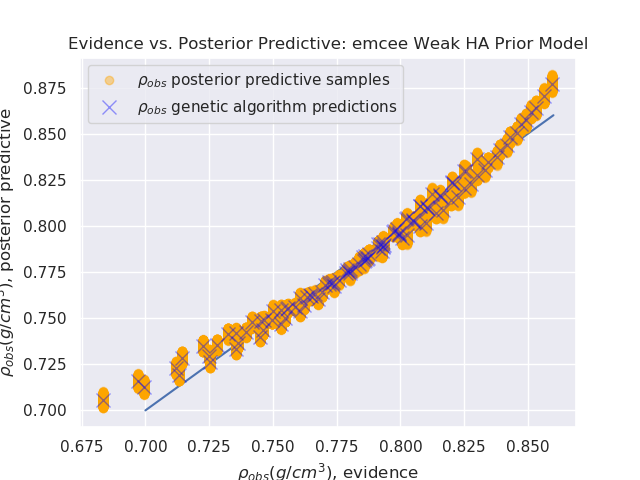

In [18]:
fig,ax = plt.subplots(ncols=1)
x = np.linspace(0.7,0.86)
ax.plot(x, x)
rand_idx_1 = np.random.randint(low=0, high=posterior_predictive_weak_emcee.shape[0], size=3000)
rand_idx_2 = np.random.randint(low=0, high=posterior_predictive_weak_emcee.shape[2], size=3000)
for i,j in zip(rand_idx_1,rand_idx_2):
    ax.plot(y, posterior_predictive_weak_emcee[i,:,j],"o",color="orange",label=r"$\rho_{obs}$ posterior predictive samples",alpha=0.4)

ax.plot(y,modelPredictions,"x",color="blue",markersize=10,label=r"$\rho_{obs}$ genetic algorithm predictions",alpha=0.4)
    
ax.set_xlabel(r"$\rho_{obs} (g/{cm}^3)$, evidence")
ax.set_ylabel(r"$\rho_{obs} (g/{cm}^3)$, posterior predictive")
ax.set_title("Evidence vs. Posterior Predictive: emcee Weak HA Prior Model")

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)
    
fig.savefig("figs/emcee_weak_HA_prior_actualvspredictedplot.png",bbox_inches='tight') 

In [36]:
posterior_predictive_weak_emcee.shape

(28000, 117, 30)

<IPython.core.display.Javascript object>


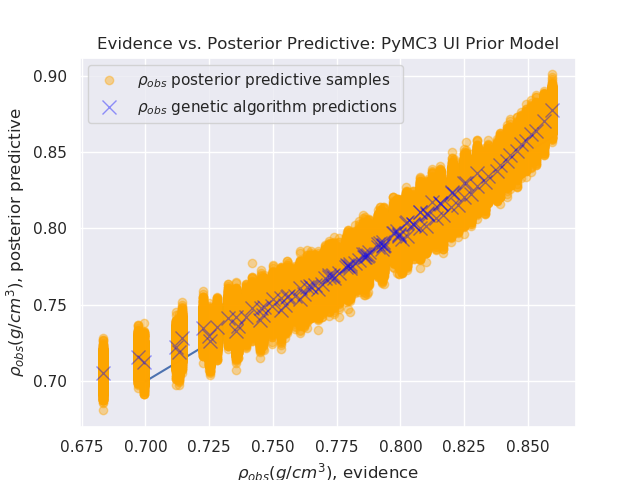

In [20]:
fig,ax = plt.subplots(ncols=1)
x = np.linspace(0.7,0.86)
ax.plot(x, x)
rand_idx = np.random.randint(low=0, high=PyMC3_UI_posterior["rho_obs"].shape[0], size=3000)
for i in rand_idx:
    plt.plot(y, PyMC3_UI_posterior["rho_obs"][i,:],"o",color="orange",label=r"$\rho_{obs}$ posterior predictive samples",alpha=0.4)

ax.plot(y,modelPredictions,"x",color="blue",markersize=10,label=r"$\rho_{obs}$ genetic algorithm predictions",alpha=0.4)    
    
ax.set_xlabel(r"$\rho_{obs} (g/{cm}^3)$, evidence")
ax.set_ylabel(r"$\rho_{obs} (g/{cm}^3)$, posterior predictive")
ax.set_title("Evidence vs. Posterior Predictive: PyMC3 UI Prior Model")

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)
    
fig.savefig("figs/PyMC3_UI_prior_actualvspredictedplot.png",bbox_inches='tight')

<IPython.core.display.Javascript object>


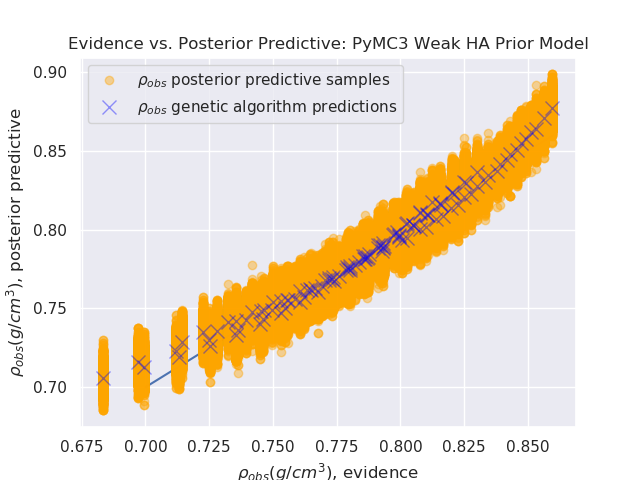

In [21]:
fig,ax = plt.subplots(ncols=1)
x = np.linspace(0.7,0.86)
ax.plot(x, x)
rand_idx = np.random.randint(low=0, high=PyMC3_weak_posterior["rho_obs"].shape[0], size=3000)
for i in rand_idx:
    plt.plot(y, PyMC3_weak_posterior["rho_obs"][i,:],"o",color="orange",label=r"$\rho_{obs}$ posterior predictive samples",alpha=0.4)

ax.plot(y,modelPredictions,"x",color="blue",markersize=10,label=r"$\rho_{obs}$ genetic algorithm predictions",alpha=0.4)    
    
ax.set_xlabel(r"$\rho_{obs} (g/{cm}^3)$, evidence")
ax.set_ylabel(r"$\rho_{obs} (g/{cm}^3)$, posterior predictive")
ax.set_title("Evidence vs. Posterior Predictive: PyMC3 Weak HA Prior Model")

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)
    
fig.savefig("figs/PyMC3_weak_HA_prior_actualvspredictedplot.png",bbox_inches='tight')

In [28]:
compare_dict = {"emcee UI": data_emcee_UI, "emcee Weak": data_emcee_weak, "emcee UI": data_pymc3_UI, "PyMC3 Weak": data_pymc3_weak}

In [29]:
print("PyMC3 Model Compariso")
az.compare(compare_dict, ic="loo", method="stacking")

PyMC3 Model Compariso


TypeError: Must be able to extract a sample_stats group from data!

In [28]:
comp=az.compare(compare_dict, ic="loo", method="stacking")

<IPython.core.display.Javascript object>


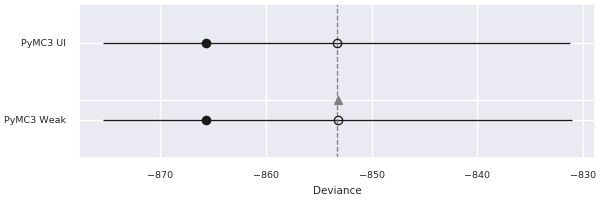

In [29]:
az.plot_compare(comp)